In [1]:
import os
import cv2 
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import keras
import tensorflow as tf
from tensorflow.python.client import device_lib
import platform
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
import random
from keras.utils import normalize

In [3]:
#Informações
print("Número de GPUs Disponiveis: ", len(tf.config.list_physical_devices('GPU')))
print("GPU: NVIDIA GeForce GTX 1070")
print("Versão Tensorflow: ",tf.__version__)
print("Versão Python: ",platform.python_version())
print("Sistema Operacional: ",platform.system(), platform.release(), "- Versão: ",platform.version())

Número de GPUs Disponiveis:  1
GPU: NVIDIA GeForce GTX 1070
Versão Tensorflow:  2.4.1
Versão Python:  3.7.9
Sistema Operacional:  Windows 10 - Versão:  10.0.19041


In [2]:
#Definição de constantes
#Tamanho das imagens/número de canais
SIZE_X=128
SIZE_Y=128
N_CHANNEL=3

#Quantidade de classes dos pixels
N_CLASSES=5 #classes: 0 a 5

## Definição de diretórios:
#### Dataset baixado de: http://www.cvlibs.net/datasets/kitti/eval_mots.php

In [3]:
#Definição do diretório das imagens
DATA_DIR_TRAINING="cvlibskitti\\training" #diretório que contém imagens de treino
DATA_DIR_MASKS="cvlibskitti\\training_masks"
DATA_FOLDER =[]

for i in tqdm(range(7)):
    DATA_FOLDER.append(sorted(os.listdir(DATA_DIR_TRAINING))[i])
    
DATA_FOLDER.append('0014')
DATA_FOLDER.append('0015')
DATA_FOLDER.append('0018')
DATA_FOLDER.append('0019')
DATA_FOLDER.append('0020')

100%|██████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 3454.54it/s]


In [4]:
#Carregar imagens de treino na memória
trainImages=[]

for p in tqdm(DATA_FOLDER):
    pathtrain=os.path.join(DATA_DIR_TRAINING,p)
    for img in sorted(os.listdir(pathtrain)):
        novaImg=cv2.imread(os.path.join(pathtrain,img)) #Le a imagem
        rgbNovaImg = cv2.cvtColor(novaImg, cv2.COLOR_BGR2RGB) #Deixa a imagem em RGB
        imgResize=cv2.resize(rgbNovaImg,(SIZE_X,SIZE_Y)) #Redimensiona a imagem para 128x128
        trainImages.append(imgResize) #Armazena imagem na lista
        
#Converter lista para numpy array   
trainImages = np.array(trainImages)

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [02:16<00:00, 11.34s/it]


In [5]:
#Carregar mascaras de treino na memória
trainMasks=[]

for p in tqdm(DATA_FOLDER):
    pathmasks=os.path.join(DATA_DIR_MASKS,p)
    for img in sorted(os.listdir(pathmasks)):
        novaImg=cv2.imread(os.path.join(pathmasks,img),0)  #Le a imagem em grayscale
        imgResize=cv2.resize(novaImg,(SIZE_X,SIZE_Y),interpolation = cv2.INTER_NEAREST) #Redimensiona a imagem para 128x128
        trainMasks.append(imgResize) #Armazena imagem na lista

#Converter lista para numpy array 
trainMasks = np.array(trainMasks)

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:57<00:00,  4.75s/it]


## Plot de Imagens de exemplo:

Shape trainImages: (4576, 128, 128, 3)
Shape trainMasks: (4576, 128, 128)

Plot Imagens de exemplo:


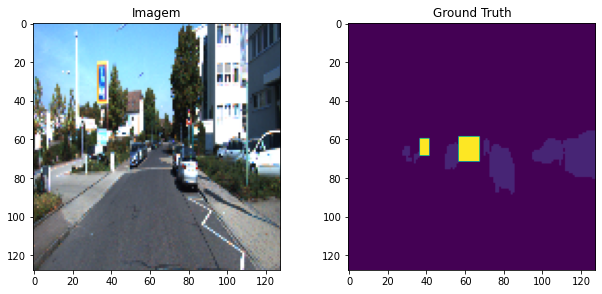

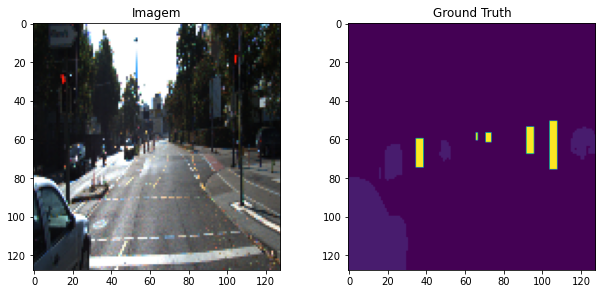

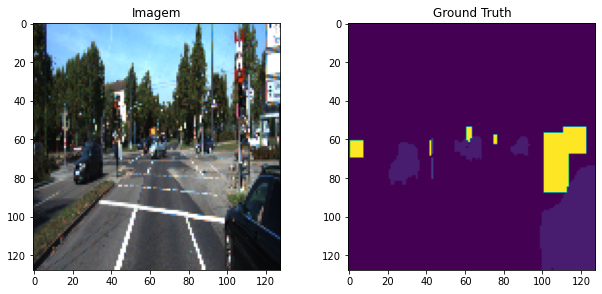

In [8]:
print("Shape trainImages:", trainImages.shape)
print("Shape trainMasks:", trainMasks.shape)

print('\nPlot Imagens de exemplo:')
#Plotar imagens de exemplo:
plt.figure(figsize=(16, 10))
plt.subplot(231)
plt.title('Imagem')
plt.imshow(trainImages[400])
plt.subplot(232)
plt.title('Ground Truth')
plt.imshow(trainMasks[400])

plt.figure(figsize=(16, 10))
plt.subplot(231)
plt.title('Imagem')
plt.imshow(trainImages[2300])
plt.subplot(232)
plt.title('Ground Truth')
plt.imshow(trainMasks[2300])

plt.figure(figsize=(16, 10))
plt.subplot(231)
plt.title('Imagem')
plt.imshow(trainImages[711])
plt.subplot(232)
plt.title('Ground Truth')
plt.imshow(trainMasks[711])

## Pré-processamento dos dados:

In [6]:
#Ajustar valores das classes
print(np.unique(trainMasks))

#converter 4 para 3
for a in tqdm(range(len(trainMasks))):
    for b in range(len(trainMasks[a])):
        for c in range(len(trainMasks[a][b])):
            if trainMasks[a][b][c]==4:
                trainMasks[a][b][c]=3


print(np.unique(trainMasks))

  0%|                                                                                 | 3/4576 [00:00<02:41, 28.37it/s]

[ 0  3  4  7  8 39]


100%|██████████████████████████████████████████████████████████████████████████████| 4576/4576 [02:46<00:00, 27.52it/s]


[ 0  3  7  8 39]


In [7]:
#Converter valores [0 3 7 8 39] para [0 1 2 3 4]
labelencoder = LabelEncoder()
n, h, w = trainMasks.shape
trainMasksReshaped = trainMasks.reshape(-1,1) #transforma em um vetor (qtd,1)
trainMasksReshapedEncoded = labelencoder.fit_transform(trainMasksReshaped) #codifica os valores
trainMasksEncodedOriginalShape = trainMasksReshapedEncoded.reshape(n, h, w) #retorna para o formato original

np.unique(trainMasksEncodedOriginalShape)

c:\users\niloc\appdata\local\programs\python\python37\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


array([0, 1, 2, 3, 4], dtype=int64)

In [8]:
#Gera o input com os labels codificados corretamente
trainMasksInput = np.expand_dims(trainMasksEncodedOriginalShape, axis=3)
np.unique(trainMasksInput)

array([0, 1, 2, 3, 4], dtype=int64)

In [9]:
print('Train Images:',trainImages.shape)
print('Train Masks Input:',trainMasksInput.shape)

Train Images: (4576, 128, 128, 3)
Train Masks Input: (4576, 128, 128, 1)


In [10]:
#Deleta variaveis da memoria
del trainMasksReshaped
del trainMasksReshapedEncoded
del trainMasksEncodedOriginalShape
del trainMasks

In [11]:
#Dividir o dataset em imagens de treino e teste (20% de 4576)
xTrain, xTest, yTrain, yTest = train_test_split(trainImages, trainMasksInput, test_size = 0.20, random_state = 0)

print("Classes nas imagens de treino: ", np.unique(yTrain))
print("Classes nas imagens de teste:  ", np.unique(yTest))

Classes nas imagens de treino:  [0 1 2 3 4]
Classes nas imagens de teste:   [0 1 2 3 4]


In [12]:
#transforma yTrain e yTest em categorical
from keras.utils import to_categorical
trainMasksCateg = to_categorical(yTrain, num_classes=N_CLASSES)

testMasksCateg = to_categorical(yTest, num_classes=N_CLASSES)

In [13]:
#Normalizar imagens de treino:
xTrainNormalized=normalize(xTrain, axis=1)
xTestNormalized=normalize(xTest, axis=1)

In [14]:
#Deleta variaveis da memoria
del yTest
del yTrain
del trainMasksInput
del trainImages

## Definição do modelo Unet:

In [15]:
#Definição do modelo Unet

def modeloUnet(n_classes, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):

    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

    #Caminho de contração
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Caminho de expansão 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    
    return model


In [16]:
#Criar Modelo
model = modeloUnet(N_CLASSES,SIZE_X,SIZE_Y,N_CHANNEL)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.MeanIoU(num_classes=5)])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 128, 128, 16) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 2320        dropout[0][0]                    
______________________________________________________________________________________________

In [35]:
#Treinar modelo
model.fit(xTrainNormalized, trainMasksCateg, batch_size = 10, verbose=1, epochs=40, validation_data=(xTestNormalized, testMasksCateg), shuffle=False)

Epoch 1/40
366/366 [==============================] - 22s 50ms/step - loss: 0.5072 - accuracy: 0.8477 - mean_io_u: 0.4017 - val_loss: 0.2958 - val_accuracy: 0.8918 - val_mean_io_u: 0.4000
Epoch 2/40
366/366 [==============================] - 17s 47ms/step - loss: 0.2855 - accuracy: 0.9034 - mean_io_u: 0.4021 - val_loss: 0.2477 - val_accuracy: 0.9144 - val_mean_io_u: 0.4000
Epoch 3/40
366/366 [==============================] - 17s 47ms/step - loss: 0.2275 - accuracy: 0.9209 - mean_io_u: 0.4138 - val_loss: 0.2115 - val_accuracy: 0.9229 - val_mean_io_u: 0.4072
Epoch 4/40
366/366 [==============================] - 17s 47ms/step - loss: 0.1916 - accuracy: 0.9330 - mean_io_u: 0.4347 - val_loss: 0.1559 - val_accuracy: 0.9467 - val_mean_io_u: 0.4146
Epoch 5/40
366/366 [==============================] - 17s 47ms/step - loss: 0.1634 - accuracy: 0.9434 - mean_io_u: 0.4641 - val_loss: 0.1410 - val_accuracy: 0.9527 - val_mean_io_u: 0.4360
Epoch 6/40
366/366 [==============================] - 17s 47

In [36]:
#Salvar modelo
model.save('modeloUnetV1.hdf5')

In [17]:
#Carregar modelo
model = keras.models.load_model('modeloUnetV1.hdf5')

## Teste da rede:

In [38]:
#Funçao para predict com test image
def testeRede():
    testImgNumber = random.randint(0, len(xTest)-1)
    testImgNormalized = xTestNormalized[testImgNumber]
    ground_truth=testMasksCateg[testImgNumber]
    testImgInput=np.expand_dims(testImgNormalized, 0)
    prediction = (model.predict(testImgInput))
    predicted_img=np.argmax(prediction, axis=-1)[0,:,:]

    print("Numero da Imagem:",testImgNumber)
    print("Shape ground truth:",ground_truth.shape)
    print("Shape prediction:",prediction[0].shape)
    print("Shape predicted_img:",predicted_img.shape)
    
    plt.figure(figsize=(12, 8))
    plt.subplot(231)
    plt.title('Imagem de teste normalizada')
    plt.imshow(xTest[testImgNumber])
    plt.subplot(232)
    plt.title('Label da imagem de teste')
    plt.imshow(ground_truth[:,:,0])
    plt.subplot(233)
    plt.title('Predição na imagem de teste')
    plt.imshow(predicted_img)
    plt.show()

Numero da Imagem: 778
Shape ground truth: (128, 128, 5)
Shape prediction: (128, 128, 5)
Shape predicted_img: (128, 128)


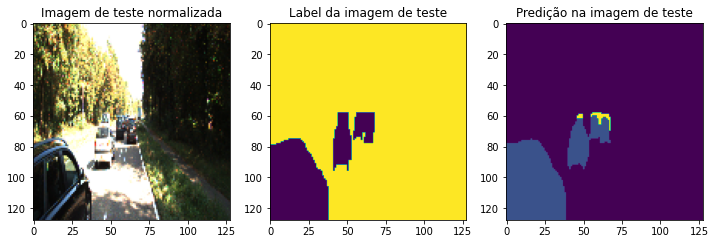

In [39]:
#Predict com test image
testeRede()

Numero da Imagem: 837
Shape ground truth: (128, 128, 5)
Shape prediction: (128, 128, 5)
Shape predicted_img: (128, 128)


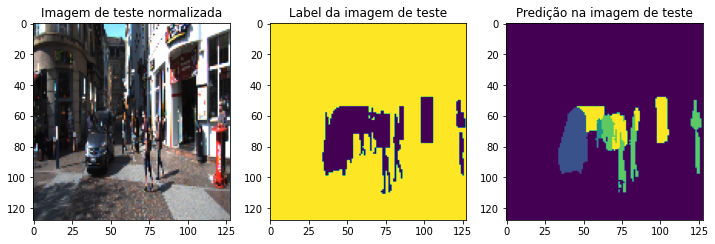

In [41]:
#Predict com test image
testeRede()

Numero da Imagem: 753
Shape ground truth: (128, 128, 5)
Shape prediction: (128, 128, 5)
Shape predicted_img: (128, 128)


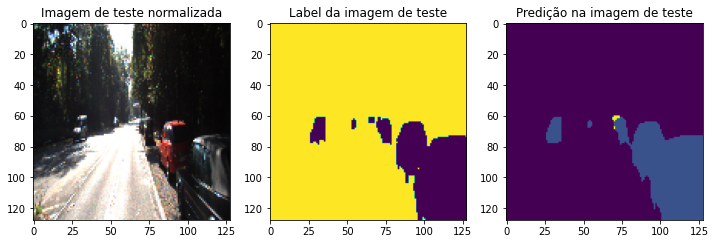

In [42]:
#Predict com test image
testeRede()

Numero da Imagem: 460
Shape ground truth: (128, 128, 5)
Shape prediction: (128, 128, 5)
Shape predicted_img: (128, 128)


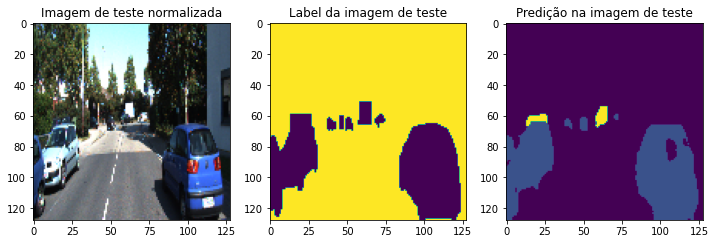

In [44]:
#Predict com test image
testeRede()

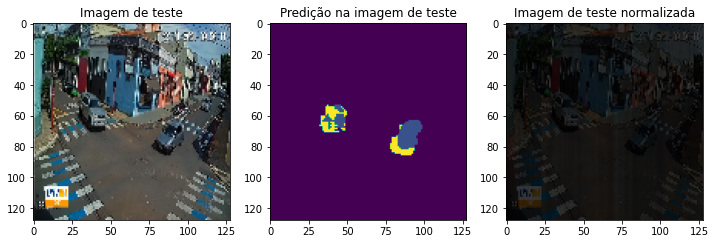

In [27]:
#Teste com imagem do video
novaImg=cv2.imread('carros.png')
rgbNovaImg = cv2.cvtColor(novaImg, cv2.COLOR_BGR2RGB)
imgResize=cv2.resize(rgbNovaImg,(SIZE_X,SIZE_Y), interpolation = cv2.INTER_NEAREST)
novaImg=np.array(imgResize)
novaImg=np.expand_dims(novaImg, 0)
novaImg= normalize(novaImg, axis=1)
novaImg.shape
prediction = (model.predict(novaImg))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]
predicted_img.shape

plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Imagem de teste')
plt.imshow(imgResize)
plt.subplot(232)
plt.title('Predição na imagem de teste')
plt.imshow(predicted_img)
plt.subplot(233)
plt.title('Imagem de teste normalizada')
plt.imshow(novaImg[0])
plt.show()